In [11]:
import json
import numpy as np

# Open and load the JSON file
with open("results/logit_result.json", "r") as file:
    data = json.load(file)

# Print the entire JSON content
similarity_matrices = [np.array(entry["similarities"]) for entry in data]  # Convert each to NumPy array
# Stack into a single 3D NumPy array (num_sentences, num_steps, num_layers)
similarity_matrices = np.stack(similarity_matrices, axis=0)
# Compute the mean similarity for each (step, layer) across sentences
average_similarities = np.mean(similarity_matrices, axis=0)

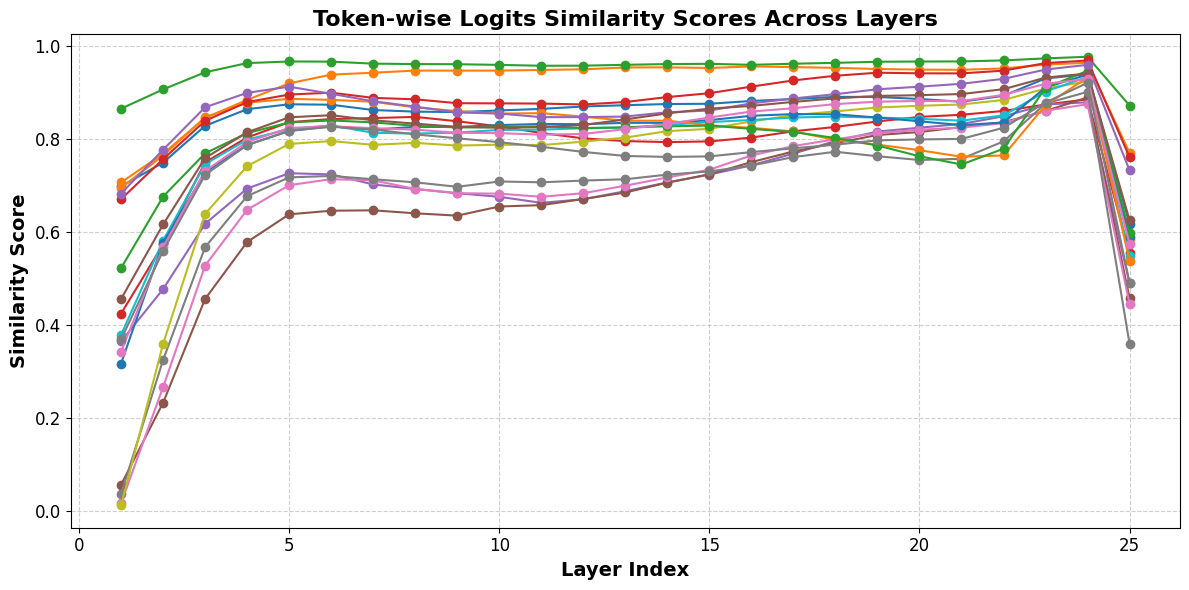

In [13]:
import matplotlib.pyplot as plt
import numpy as np

similarities = average_similarities[2:, :]  # Excludes first two rows (tokens)

# Number of tokens and layers
num_tokens, num_layers = similarities.shape

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each token's similarity score across layers
for token_idx in range(num_tokens):
    plt.plot(range(1, num_layers + 1), similarities[token_idx], marker="o", linestyle="-", label=f"Token {token_idx+1}")

# Styling
plt.xlabel("Layer Index", fontsize=14, fontweight="bold")
plt.ylabel("Similarity Score", fontsize=14, fontweight="bold")
plt.title("Token-wise Logits Similarity Scores Across Layers", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
import json

# Open and load the JSON file
with open("results/flores_results.json", "r") as file:
    flores_data = json.load(file)

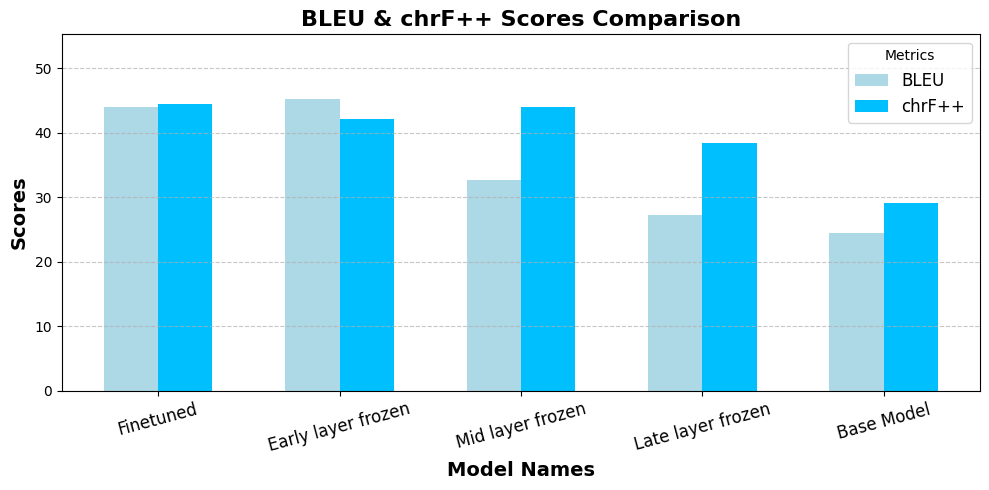

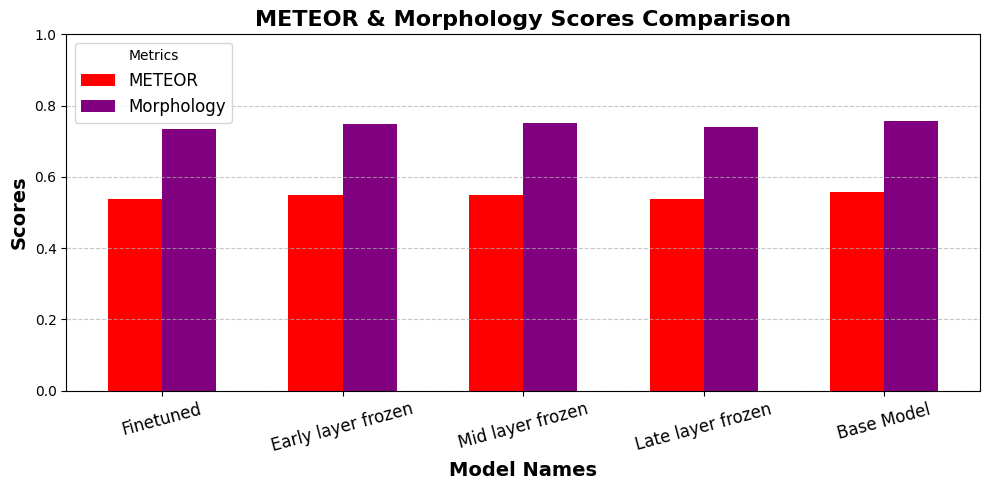

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
models = ["Finetuned", "Early layer frozen", "Mid layer frozen", "Late layer frozen", "Base Model"]  # Model names
numbers = [0, 3, 2, 4, 5]

# Extracting scores
bleu_scores = [flores_data[i]["BLEU"] for i in numbers]
chrf_scores = [flores_data[i]["chrF++"] for i in numbers]
meteor_scores = [flores_data[i]["METEOR"] for i in numbers]
morph_scores = [flores_data[i]["Morph"] for i in numbers]

# Define bar width and positions
x = np.arange(len(models))
bar_width = 0.3

# Create first bar plot (BLEU & chrF++)
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width / 2, bleu_scores, width=bar_width, label="BLEU", color="lightblue")
plt.bar(x + bar_width / 2, chrf_scores, width=bar_width, label="chrF++", color="deepskyblue")

# Formatting for first plot
plt.xlabel("Model Names", fontsize=14, fontweight="bold")
plt.ylabel("Scores", fontsize=14, fontweight="bold")
plt.title("BLEU & chrF++ Scores Comparison", fontsize=16, fontweight="bold")
plt.xticks(ticks=x, labels=models, fontsize=12, rotation=15)
plt.legend(fontsize=12, title="Metrics")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, max(max(bleu_scores), max(chrf_scores)) + 10)  # Adjust y-axis limit for better visibility

plt.tight_layout()
plt.show()

# Create second bar plot (METEOR & Morphology)
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width / 2, meteor_scores, width=bar_width, label="METEOR", color="red")
plt.bar(x + bar_width / 2, morph_scores, width=bar_width, label="Morphology", color="purple")

# Formatting for second plot
plt.xlabel("Model Names", fontsize=14, fontweight="bold")
plt.ylabel("Scores", fontsize=14, fontweight="bold")
plt.title("METEOR & Morphology Scores Comparison", fontsize=16, fontweight="bold")
plt.xticks(ticks=x, labels=models, fontsize=12, rotation=15)
plt.legend(fontsize=12, title="Metrics")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)  # Adjust y-axis limit for better visibility

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
from collections import Counter

def extract_morph_features(sentence):
    """
    Dummy function to extract morphological features.
    In a real setup, use spaCy or a morphological parser for accurate extraction.
    """
    return [{"word": word, "feats": word[-1]} for word in sentence.split()]  # Placeholder

def compare_morph_features(reference, hypothesis):
    """
    Compares the morphological features between the reference and the translated hypothesis.
    """
    ref_features = extract_morph_features(reference)
    hyp_features = extract_morph_features(hypothesis)

    ref_feats_count = Counter([word["feats"] for word in ref_features if word["feats"]])
    hyp_feats_count = Counter([word["feats"] for word in hyp_features if word["feats"]])

    shared_feats = sum((ref_feats_count & hyp_feats_count).values())
    total_feats = sum(ref_feats_count.values())

    morph_similarity = shared_feats / total_feats if total_feats > 0 else 0
    return morph_similarity

def evaluate_morphology(reference_sentences, hypothesis_sentences):
    """
    Evaluates how well the translation preserves morphology across multiple sentences.
    """
    similarities = []
    for ref, hyp in zip(reference_sentences, hypothesis_sentences):
        result = compare_morph_features(ref, hyp)
        similarities.append(result)
    
    avg_similarity = sum(similarities) / len(similarities) if similarities else 0
    return avg_similarity

# Load reference and hypothesis translations
with open("reference_sentences.txt", "r") as ref_file:
    reference_sentences = [line.strip() for line in ref_file.readlines()]

# Assuming flores_results.json contains hypothesis translations
import json
with open("results/layer_wise_flores_results.json", "r") as hyp_file:
    flores_data = json.load(hyp_file)

# Compute morphology scores and update dataset
morph_scores = [
    evaluate_morphology(reference_sentences, flores_data[i]["Predictions"])
    for i in range(len(flores_data))
]

# Extract disabled LoRA information
disabled_lora_layers = [
    flores_data[i].get("Frozen Layers", "None") for i in range(len(flores_data))
]

# Update DataFrame
data = {
    "Model": [
        f"{flores_data[i]['Model Name']}" for i in range(len(flores_data))
    ],
    "Encoder/Decoder": [
        f"{flores_data[i]['Encoder/Decoder']}" for i in range(len(flores_data))
    ],
    "Disabled_LoRA_Layers": disabled_lora_layers,
    "BLEU": [flores_data[i]["BLEU"] for i in range(len(flores_data))],
    "chrF++": [flores_data[i]["chrF++"] for i in range(len(flores_data))],
    "METEOR": [flores_data[i]["METEOR"] for i in range(len(flores_data))],
    "Morphology": morph_scores
}

df = pd.DataFrame(data)

In [ ]:
df.to_csv("results/updated_flores_results.csv", index=False)

In [21]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Filter decoder rows
decoder_df = df[df['Encoder/Decoder'] == 'decoder'].copy()

# Extract the single integer from the list and sort by that integer
decoder_df['Disabled_LoRA_Layers_Int'] = decoder_df['Disabled_LoRA_Layers'].apply(lambda x: x[0])
decoder_df_sorted = decoder_df.sort_values('Disabled_LoRA_Layers_Int').drop('Disabled_LoRA_Layers', axis=1)

In [22]:
decoder_df_sorted

,Model,Encoder/Decoder,BLEU,chrF++,METEOR,Morphology,Disabled_LoRA_Layers_Int
0,Billyyy/mon_nllb_1.3B,decoder,45.298529,42.123201,0.539790,0.725053,0
1,Billyyy/mon_nllb_1.3B,decoder,44.058638,44.426093,0.538975,0.724336,1
2,Billyyy/mon_nllb_1.3B,decoder,32.905806,40.739016,0.540539,0.727462,2
3,Billyyy/mon_nllb_1.3B,decoder,45.298529,42.123201,0.539926,0.724853,3
11,Billyyy/mon_nllb_1.3B,decoder,44.058638,44.426093,0.541890,0.727373,4
12,Billyyy/mon_nllb_1.3B,decoder,44.058638,44.426093,0.543642,0.726566,5
13,Billyyy/mon_nllb_1.3B,decoder,43.185757,41.833140,0.541676,0.727231,6
14,Billyyy/mon_nllb_1.3B,decoder,33.758047,38.378440,0.538906,0.726098,7
15,Billyyy/mon_nllb_1.3B,decoder,42.565922,43.114150,0.542868,0.730784,8
16,Billyyy/mon_nllb_1.3B,decoder,32.905806,40.739016,0.538181,0.723902,9


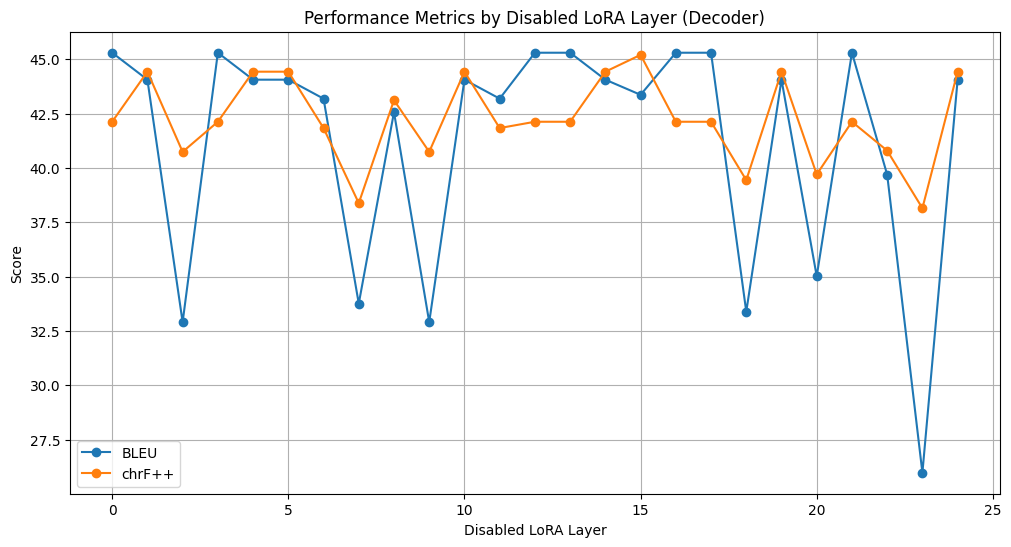

In [24]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(decoder_df_sorted['Disabled_LoRA_Layers_Int'], decoder_df_sorted['BLEU'], marker='o', label='BLEU')
plt.plot(decoder_df_sorted['Disabled_LoRA_Layers_Int'], decoder_df_sorted['chrF++'], marker='o', label='chrF++')

plt.xlabel('Disabled LoRA Layer')
plt.ylabel('Score')
plt.title('Performance Metrics by Disabled LoRA Layer (Decoder)')
plt.legend()
plt.grid(True)
plt.show()

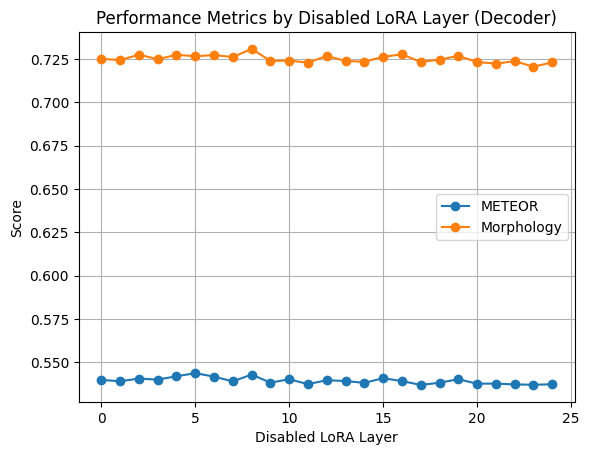

In [25]:
plt.plot(decoder_df_sorted['Disabled_LoRA_Layers_Int'], decoder_df_sorted['METEOR'], marker='o', label='METEOR')
plt.plot(decoder_df_sorted['Disabled_LoRA_Layers_Int'], decoder_df_sorted['Morphology'], marker='o', label='Morphology')


plt.xlabel('Disabled LoRA Layer')
plt.ylabel('Score')
plt.title('Performance Metrics by Disabled LoRA Layer (Decoder)')
plt.legend()
plt.grid(True)
plt.show()